In [24]:
# Import required libraries
import sys
sys.path.append('../..')

from utilities.performance_utils import PerformanceTracker, benchmark_operation, generate_test_data
from configs.cdf_config import config
import pandas as pd
import numpy as np
import time
from datetime import datetime, timedelta

# Import CDF SDK objects
from cognite.client.data_classes import TimeSeries, Datapoints

# For plotting (optional)
try:
    import matplotlib.pyplot as plt
    plt.style.use('default')
except ImportError:
    print("Matplotlib not available. Install with: pip install matplotlib")


In [25]:
# Initialize CDF client using the client setup utility
from utilities.client_setup import get_client, test_connection

# Get the configured CDF client
client = get_client()

if client is None:
    print("Failed to create CDF client. Please check your .env file.")
    print("Run: python ../../test_connection.py to test your connection")
else:
    # Test the connection
    if test_connection():
        print("Ready to run performance tests!")
    else:
        print("Connection test failed. Please check your credentials.")


✓ Successfully connected to CDF project: templates-dev
🔍 Testing CDF connection...
📋 Current .env configuration:
----------------------------------------
  CDF_PROJECT: templates-dev
  CDF_CLUSTER: aws-dub-dev
  CDF_BASE_URL: https://aws-dub-dev.cognitedata.com
  DEFAULT_BATCH_SIZE: 1000
  DEFAULT_ITERATIONS: 10
  LOG_LEVEL: INFO
  CDF_CLIENT_ID: 8242****************************a218
  CDF_CLIENT_SECRET: KN98********************************fb.o
  CDF_TENANT_ID: b897****************************1a62
----------------------------------------
✓ Configuration is valid
✓ Successfully connected to CDF project: templates-dev
✓ Connection successful!
  Project: templates-dev
  Token is valid and accessible
Ready to run performance tests!


In [26]:
# Setup: Create test time series with historical data for query testing
def setup_test_timeseries(num_series=5, days_of_data=30, interval_minutes=1):
    """
    Create test time series with historical data for query performance testing.
    
    Args:
        num_series: Number of time series to create
        days_of_data: Days of historical data to generate
        interval_minutes: Interval between datapoints in minutes
    
    Returns:
        List of created time series external IDs
    """
    if client is None:
        print("❌ Cannot setup test data: CDF client is not initialized.")
        return []
    
    print(f"Setting up {num_series} test time series with {days_of_data} days of data...")
    
    # Calculate time range
    end_time = int(time.time() * 1000)  # Current time in milliseconds
    start_time = end_time - (days_of_data * 24 * 60 * 60 * 1000)  # X days ago
    interval_ms = interval_minutes * 60 * 1000
    
    created_series = []
    
    try:
        for i in range(num_series):
            ts_external_id = f"query_perf_test_{i}_{int(time.time())}"
            
            # Create time series
            ts = client.time_series.create(
                TimeSeries(
                    external_id=ts_external_id,
                    name=f"Query Performance Test Series {i}",
                    description=f"Test time series for query performance testing (series {i})"
                )
            )
            
            # Generate historical data
            timestamps = list(range(start_time, end_time, interval_ms))
            # Create realistic-looking data with some patterns
            values = [
                50 + 10 * np.sin(2 * np.pi * j / (24 * 60 / interval_minutes)) +  # Daily pattern
                5 * np.sin(2 * np.pi * j / (7 * 24 * 60 / interval_minutes)) +   # Weekly pattern
                np.random.normal(0, 2)  # Random noise
                for j in range(len(timestamps))
            ]
            
            datapoints = list(zip(timestamps, values))
            
            # Insert data in batches to avoid timeout
            batch_size = 10000
            for batch_start in range(0, len(datapoints), batch_size):
                batch_end = min(batch_start + batch_size, len(datapoints))
                batch_data = datapoints[batch_start:batch_end]
                
                client.time_series.data.insert(
                    batch_data,
                    external_id=ts_external_id
                )
            
            created_series.append(ts_external_id)
            print(f"  ✓ Created series {i+1}/{num_series}: {len(datapoints)} datapoints")
    
    except Exception as e:
        print(f"❌ Error creating test data: {e}")
        # Clean up any created series
        for ts_id in created_series:
            try:
                client.time_series.delete(external_id=ts_id)
            except:
                pass
        return []
    
    print(f"✅ Setup complete! Created {len(created_series)} time series")
    return created_series

# Create test data (adjust parameters as needed)
if client is not None:
    test_series = setup_test_timeseries(num_series=3, days_of_data=7, interval_minutes=5)
else:
    test_series = []
    print("⚠️ Skipping setup - CDF client not available")


Setting up 3 test time series with 7 days of data...
  ✓ Created series 1/3: 2016 datapoints
  ✓ Created series 2/3: 2016 datapoints
  ✓ Created series 3/3: 2016 datapoints
✅ Setup complete! Created 3 time series


In [27]:
# Test 1: Range Query Performance - Different Time Spans
def test_range_query_performance(test_series):
    """Test query performance with different time ranges."""
    
    if not test_series or client is None:
        print("❌ Cannot run test: No test series available or client not initialized.")
        return None
    
    print("🔍 Testing range query performance with different time spans...")
    
    # Define different time spans to test
    time_spans = {
        "1 hour": 1 * 60 * 60 * 1000,
        "6 hours": 6 * 60 * 60 * 1000,
        "1 day": 24 * 60 * 60 * 1000,
        "3 days": 3 * 24 * 60 * 60 * 1000,
        "1 week": 7 * 24 * 60 * 60 * 1000
    }
    
    results = {}
    end_time = int(time.time() * 1000)
    
    for span_name, span_ms in time_spans.items():
        print(f"  Testing {span_name} range...")
        start_time = end_time - span_ms
        
        tracker = PerformanceTracker(f"range_query_{span_name.replace(' ', '_')}")
        
        # Test with the first series
        ts_external_id = test_series[0]
        
        def query_range():
            return client.time_series.data.retrieve(
                external_id=ts_external_id,
                start=start_time,
                end=end_time
            )
        
        # Benchmark the query
        try:
            benchmark_results = benchmark_operation(query_range, iterations=10, warmup=2)
            results[span_name] = benchmark_results
            
            # Get a sample to count datapoints
            sample_data = query_range()
            datapoint_count = len(sample_data) if sample_data else 0
            
            print(f"    Mean time: {benchmark_results['mean_time']:.4f}s")
            print(f"    Datapoints: {datapoint_count}")
            print(f"    Throughput: {datapoint_count / benchmark_results['mean_time']:.2f} datapoints/s")
            
        except Exception as e:
            print(f"    ❌ Error: {e}")
            results[span_name] = None
    
    return results

# Run range query test
if test_series:
    range_results = test_range_query_performance(test_series)
else:
    print("⚠️ Skipping range query test - no test series available")


🔍 Testing range query performance with different time spans...
  Testing 1 hour range...
    Mean time: 0.0875s
    Datapoints: 11
    Throughput: 125.78 datapoints/s
  Testing 6 hours range...
    Mean time: 0.0807s
    Datapoints: 71
    Throughput: 880.06 datapoints/s
  Testing 1 day range...
    Mean time: 0.0833s
    Datapoints: 287
    Throughput: 3445.98 datapoints/s
  Testing 3 days range...
    Mean time: 0.0904s
    Datapoints: 863
    Throughput: 9542.11 datapoints/s
  Testing 1 week range...
    Mean time: 0.0879s
    Datapoints: 2015
    Throughput: 22936.20 datapoints/s


In [28]:
# Test 2: Aggregate Query Performance
def test_aggregate_query_performance(test_series):
    """Test performance of aggregate queries with different granularities."""
    
    if not test_series or client is None:
        print("❌ Cannot run test: No test series available or client not initialized.")
        return None
    
    print("📊 Testing aggregate query performance...")
    
    # Define different granularities to test
    granularities = ["1m", "15m", "1h", "6h", "1d"]
    aggregates = ["average", "min", "max", "count"]
    
    results = {}
    end_time = int(time.time() * 1000)
    start_time = end_time - (7 * 24 * 60 * 60 * 1000)  # 1 week of data
    
    for granularity in granularities:
        print(f"  Testing granularity: {granularity}")
        
        tracker = PerformanceTracker(f"aggregate_query_{granularity}")
        
        # Test with the first series
        ts_external_id = test_series[0]
        
        def query_aggregates():
            return client.time_series.data.retrieve(
                external_id=ts_external_id,
                start=start_time,
                end=end_time,
                granularity=granularity,
                aggregates=aggregates
            )
        
        # Benchmark the aggregate query
        try:
            benchmark_results = benchmark_operation(query_aggregates, iterations=5, warmup=1)
            results[granularity] = benchmark_results
            
            # Get a sample to count datapoints
            sample_data = query_aggregates()
            datapoint_count = len(sample_data) if sample_data else 0
            
            print(f"    Mean time: {benchmark_results['mean_time']:.4f}s")
            print(f"    Aggregated points: {datapoint_count}")
            print(f"    Throughput: {datapoint_count / benchmark_results['mean_time']:.2f} points/s")
            
        except Exception as e:
            print(f"    ❌ Error: {e}")
            results[granularity] = None
    
    return results

# Run aggregate query test
if test_series:
    aggregate_results = test_aggregate_query_performance(test_series)
else:
    print("⚠️ Skipping aggregate query test - no test series available")


📊 Testing aggregate query performance...
  Testing granularity: 1m
    Mean time: 0.1198s
    Aggregated points: 2016
    Throughput: 16835.06 points/s
  Testing granularity: 15m
    Mean time: 0.1114s
    Aggregated points: 672
    Throughput: 6032.02 points/s
  Testing granularity: 1h
    Mean time: 0.0916s
    Aggregated points: 169
    Throughput: 1845.39 points/s
  Testing granularity: 6h
    Mean time: 0.0822s
    Aggregated points: 29
    Throughput: 352.68 points/s
  Testing granularity: 1d
    Mean time: 0.0858s
    Aggregated points: 8
    Throughput: 93.28 points/s


In [29]:
# Test 3: Multiple Time Series Query Performance
def test_multiple_series_query_performance(test_series):
    """Test performance when querying multiple time series simultaneously."""
    
    if not test_series or client is None:
        print("❌ Cannot run test: No test series available or client not initialized.")
        return None
    
    print("🔗 Testing multiple time series query performance...")
    
    # Test with different numbers of series
    series_counts = [1, 2, 3] if len(test_series) >= 3 else [1, len(test_series)]
    
    results = {}
    end_time = int(time.time() * 1000)
    start_time = end_time - (24 * 60 * 60 * 1000)  # 1 day of data
    
    for count in series_counts:
        print(f"  Testing {count} series simultaneously...")
        
        tracker = PerformanceTracker(f"multi_series_{count}")
        
        series_subset = test_series[:count]
        
        def query_multiple():
            # Query multiple series using retrieve with list of external_ids
            return client.time_series.data.retrieve(
                external_id=series_subset,
                start=start_time,
                end=end_time
            )
        
        # Benchmark the multi-series query
        try:
            benchmark_results = benchmark_operation(query_multiple, iterations=5, warmup=1)
            results[f"{count}_series"] = benchmark_results
            
            # Get a sample to count total datapoints
            try:
                sample_data = query_multiple()
                total_datapoints = len(sample_data) if sample_data else 0
            except Exception:
                total_datapoints = 0
            
            print(f"    Mean time: {benchmark_results['mean_time']:.4f}s")
            print(f"    Total datapoints: {total_datapoints}")
            print(f"    Throughput: {total_datapoints / benchmark_results['mean_time']:.2f} datapoints/s")
            print(f"    Per series throughput: {total_datapoints / (count * benchmark_results['mean_time']):.2f} datapoints/s/series")
            
        except Exception as e:
            print(f"    ❌ Error: {e}")
            results[f"{count}_series"] = None
    
    return results

# Run multiple series query test
if test_series:
    multi_results = test_multiple_series_query_performance(test_series)
else:
    print("⚠️ Skipping multiple series query test - no test series available")


🔗 Testing multiple time series query performance...
  Testing 1 series simultaneously...
    Mean time: 0.0869s
    Total datapoints: 1
    Throughput: 11.51 datapoints/s
    Per series throughput: 11.51 datapoints/s/series
  Testing 2 series simultaneously...
    Mean time: 0.0808s
    Total datapoints: 2
    Throughput: 24.76 datapoints/s
    Per series throughput: 12.38 datapoints/s/series
  Testing 3 series simultaneously...
    Mean time: 0.0828s
    Total datapoints: 3
    Throughput: 36.24 datapoints/s
    Per series throughput: 12.08 datapoints/s/series


In [30]:
# Test 4: Limit Parameter Optimization
def test_limit_parameter_performance(test_series):
    """Test performance impact of limit parameter."""
    
    if not test_series or client is None:
        print("❌ Cannot run test: No test series available or client not initialized.")
        return None
    
    print("🎯 Testing limit parameter performance...")
    
    # Test different limit values
    limits = [100, 500, 1000, 5000, 10000, None]  # None means no limit
    
    results = {}
    end_time = int(time.time() * 1000)
    start_time = end_time - (7 * 24 * 60 * 60 * 1000)  # 1 week of data
    
    for limit in limits:
        limit_name = f"limit_{limit}" if limit else "no_limit"
        print(f"  Testing with limit: {limit if limit else 'None'}")
        
        tracker = PerformanceTracker(f"limit_test_{limit_name}")
        
        # Test with the first series
        ts_external_id = test_series[0]
        
        def query_with_limit():
            if limit:
                return client.time_series.data.retrieve(
                    external_id=ts_external_id,
                    start=start_time,
                    end=end_time,
                    limit=limit
                )
            else:
                return client.time_series.data.retrieve(
                    external_id=ts_external_id,
                    start=start_time,
                    end=end_time
                )
        
        # Benchmark the limited query
        try:
            benchmark_results = benchmark_operation(query_with_limit, iterations=5, warmup=1)
            results[limit_name] = benchmark_results
            
            # Get a sample to count datapoints
            sample_data = query_with_limit()
            datapoint_count = len(sample_data) if sample_data else 0
            
            print(f"    Mean time: {benchmark_results['mean_time']:.4f}s")
            print(f"    Retrieved datapoints: {datapoint_count}")
            if limit and datapoint_count >= limit:
                print(f"    ⚠️  Hit limit: {limit}")
            print(f"    Throughput: {datapoint_count / benchmark_results['mean_time']:.2f} datapoints/s")
            
        except Exception as e:
            print(f"    ❌ Error: {e}")
            results[limit_name] = None
    
    return results

# Run limit parameter test
if test_series:
    limit_results = test_limit_parameter_performance(test_series)
else:
    print("⚠️ Skipping limit parameter test - no test series available")


🎯 Testing limit parameter performance...
  Testing with limit: 100
    Mean time: 0.0787s
    Retrieved datapoints: 100
    ⚠️  Hit limit: 100
    Throughput: 1269.87 datapoints/s
  Testing with limit: 500
    Mean time: 0.0804s
    Retrieved datapoints: 500
    ⚠️  Hit limit: 500
    Throughput: 6219.45 datapoints/s
  Testing with limit: 1000
    Mean time: 0.0976s
    Retrieved datapoints: 1000
    ⚠️  Hit limit: 1000
    Throughput: 10244.95 datapoints/s
  Testing with limit: 5000
    Mean time: 0.0854s
    Retrieved datapoints: 2015
    Throughput: 23581.68 datapoints/s
  Testing with limit: 10000
    Mean time: 0.0885s
    Retrieved datapoints: 2015
    Throughput: 22774.38 datapoints/s
  Testing with limit: None
    Mean time: 0.0901s
    Retrieved datapoints: 2015
    Throughput: 22351.79 datapoints/s


In [31]:
# Test 5: Latest Value Query Performance
def test_latest_value_performance(test_series):
    """Test performance of retrieving latest values."""
    
    if not test_series or client is None:
        print("❌ Cannot run test: No test series available or client not initialized.")
        return None
    
    print("⏰ Testing latest value query performance...")
    
    results = {}
    
    # Test single series latest value
    print("  Testing single series latest value...")
    ts_external_id = test_series[0]
    
    def query_single_latest():
        return client.time_series.data.retrieve_latest(
            external_id=ts_external_id
        )
    
    try:
        single_results = benchmark_operation(query_single_latest, iterations=20, warmup=3)
        results["single_latest"] = single_results
        
        print(f"    Mean time: {single_results['mean_time']:.4f}s")
        print(f"    Operations/sec: {single_results['operations_per_second']:.2f}")
        
    except Exception as e:
        print(f"    ❌ Error: {e}")
        results["single_latest"] = None
    
    # Test multiple series latest values
    if len(test_series) > 1:
        print("  Testing multiple series latest values...")
        
        def query_multiple_latest():
            return client.time_series.data.retrieve_latest(
                external_id=test_series
            )
        
        try:
            multi_results = benchmark_operation(query_multiple_latest, iterations=10, warmup=2)
            results["multiple_latest"] = multi_results
            
            print(f"    Mean time: {multi_results['mean_time']:.4f}s")
            print(f"    Series count: {len(test_series)}")
            print(f"    Time per series: {multi_results['mean_time'] / len(test_series):.4f}s")
            
        except Exception as e:
            print(f"    ❌ Error: {e}")
            results["multiple_latest"] = None
    
    return results

# Run latest value test
if test_series:
    latest_results = test_latest_value_performance(test_series)
else:
    print("⚠️ Skipping latest value test - no test series available")


⏰ Testing latest value query performance...
  Testing single series latest value...
    Mean time: 0.0764s
    Operations/sec: 13.09
  Testing multiple series latest values...
    Mean time: 0.0767s
    Series count: 3
    Time per series: 0.0256s


📈 Performance Test Results Summary

🔍 Range Query Performance:
  1 hour     | 0.0875s avg | 11.43 ops/s
  6 hours    | 0.0807s avg | 12.40 ops/s
  1 day      | 0.0833s avg | 12.01 ops/s
  3 days     | 0.0904s avg | 11.06 ops/s
  1 week     | 0.0879s avg | 11.38 ops/s

📊 Aggregate Query Performance:
  1m         | 0.1198s avg | 8.35 ops/s
  15m        | 0.1114s avg | 8.98 ops/s
  1h         | 0.0916s avg | 10.92 ops/s
  6h         | 0.0822s avg | 12.16 ops/s
  1d         | 0.0858s avg | 11.66 ops/s

🔗 Multiple Series Query Performance:
  1_series   | 0.0869s avg | 11.51 ops/s
  2_series   | 0.0808s avg | 12.38 ops/s
  3_series   | 0.0828s avg | 12.08 ops/s

🎯 Limit Parameter Performance:
  limit_100    | 0.0787s avg | 12.70 ops/s
  limit_500    | 0.0804s avg | 12.44 ops/s
  limit_1000   | 0.0976s avg | 10.24 ops/s
  limit_5000   | 0.0854s avg | 11.70 ops/s
  limit_10000  | 0.0885s avg | 11.30 ops/s
  no_limit     | 0.0901s avg | 11.09 ops/s

⏰ Latest Value Query Performance:
  single_la

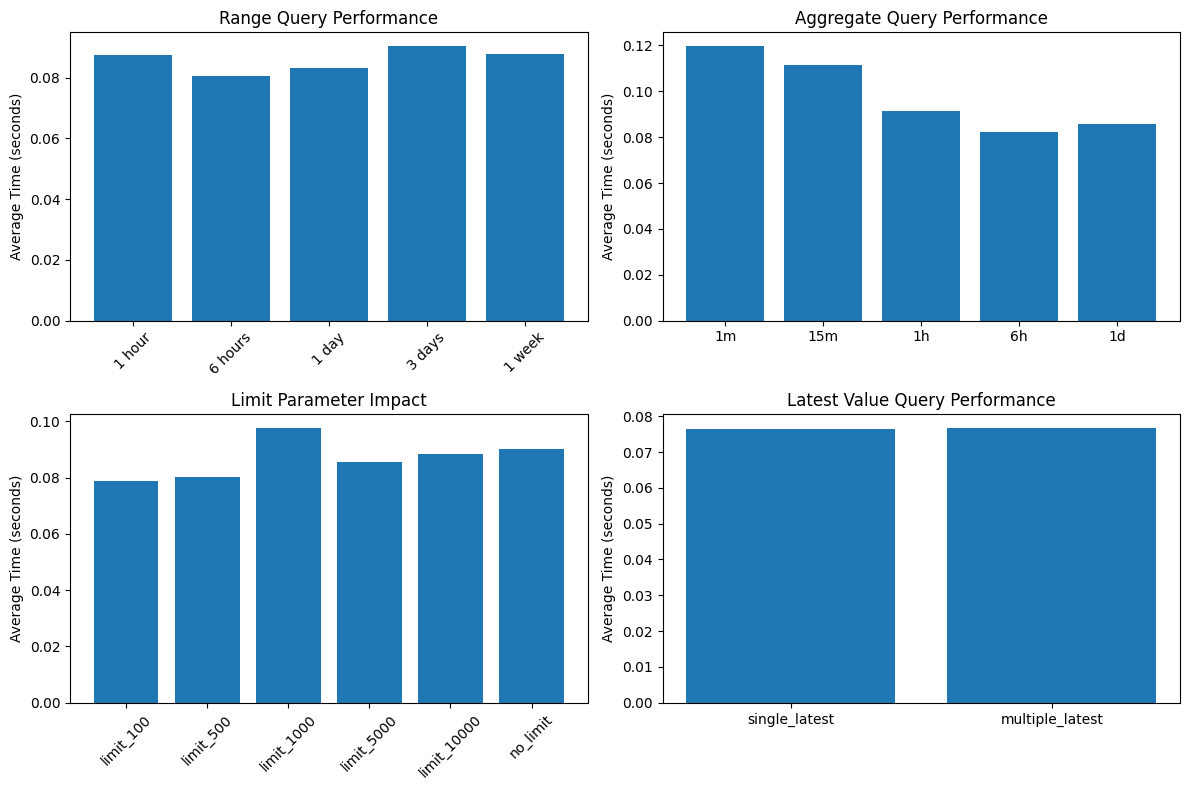


✅ Performance testing complete!
📋 Test series created: 3
💾 Results can be saved using the PerformanceTracker.save_results() method


In [32]:
# Performance Results Summary and Visualization
def summarize_and_visualize_results():
    """Summarize all performance test results and create visualizations."""
    
    if not test_series:
        print("❌ No test results to summarize - test series not available.")
        return
    
    print("📈 Performance Test Results Summary")
    print("=" * 50)
    
    # Summarize each test
    if 'range_results' in globals() and range_results:
        print("\n🔍 Range Query Performance:")
        for span, results in range_results.items():
            if results:
                print(f"  {span:10} | {results['mean_time']:.4f}s avg | {results['operations_per_second']:.2f} ops/s")
    
    if 'aggregate_results' in globals() and aggregate_results:
        print("\n📊 Aggregate Query Performance:")
        for granularity, results in aggregate_results.items():
            if results:
                print(f"  {granularity:10} | {results['mean_time']:.4f}s avg | {results['operations_per_second']:.2f} ops/s")
    
    if 'multi_results' in globals() and multi_results:
        print("\n🔗 Multiple Series Query Performance:")
        for series_count, results in multi_results.items():
            if results:
                print(f"  {series_count:10} | {results['mean_time']:.4f}s avg | {results['operations_per_second']:.2f} ops/s")
    
    if 'limit_results' in globals() and limit_results:
        print("\n🎯 Limit Parameter Performance:")
        for limit, results in limit_results.items():
            if results:
                print(f"  {limit:12} | {results['mean_time']:.4f}s avg | {results['operations_per_second']:.2f} ops/s")
    
    if 'latest_results' in globals() and latest_results:
        print("\n⏰ Latest Value Query Performance:")
        for test_type, results in latest_results.items():
            if results:
                print(f"  {test_type:15} | {results['mean_time']:.4f}s avg | {results['operations_per_second']:.2f} ops/s")
    
    # Create simple visualization if matplotlib is available
    try:
        import matplotlib.pyplot as plt
        
        # Plot range query performance
        if 'range_results' in globals() and range_results:
            plt.figure(figsize=(12, 8))
            
            # Range query times
            plt.subplot(2, 2, 1)
            spans = [span for span, results in range_results.items() if results]
            times = [range_results[span]['mean_time'] for span in spans]
            plt.bar(spans, times)
            plt.title('Range Query Performance')
            plt.ylabel('Average Time (seconds)')
            plt.xticks(rotation=45)
            
            # Aggregate query times
            if 'aggregate_results' in globals() and aggregate_results:
                plt.subplot(2, 2, 2)
                granularities = [g for g, results in aggregate_results.items() if results]
                agg_times = [aggregate_results[g]['mean_time'] for g in granularities]
                plt.bar(granularities, agg_times)
                plt.title('Aggregate Query Performance')
                plt.ylabel('Average Time (seconds)')
            
            # Limit parameter impact
            if 'limit_results' in globals() and limit_results:
                plt.subplot(2, 2, 3)
                limits = [l for l, results in limit_results.items() if results]
                limit_times = [limit_results[l]['mean_time'] for l in limits]
                plt.bar(limits, limit_times)
                plt.title('Limit Parameter Impact')
                plt.ylabel('Average Time (seconds)')
                plt.xticks(rotation=45)
            
            # Latest value performance
            if 'latest_results' in globals() and latest_results:
                plt.subplot(2, 2, 4)
                latest_types = [t for t, results in latest_results.items() if results]
                latest_times = [latest_results[t]['mean_time'] for t in latest_types]
                plt.bar(latest_types, latest_times)
                plt.title('Latest Value Query Performance')
                plt.ylabel('Average Time (seconds)')
            
            plt.tight_layout()
            plt.show()
            
    except ImportError:
        print("\n📊 Install matplotlib for visualizations: pip install matplotlib")
    
    print(f"\n✅ Performance testing complete!")
    print(f"📋 Test series created: {len(test_series)}")
    print(f"💾 Results can be saved using the PerformanceTracker.save_results() method")

# Generate summary
summarize_and_visualize_results()


In [33]:
# 🧹 CLEANUP: Remove test time series
def cleanup_test_data(test_series):
    """Clean up the test time series created for performance testing."""
    
    if not test_series or client is None:
        print("❌ Cannot cleanup: No test series or client not available.")
        return
    
    print(f"🧹 Cleaning up {len(test_series)} test time series...")
    
    successfully_deleted = 0
    
    for ts_external_id in test_series:
        try:
            client.time_series.delete(external_id=ts_external_id)
            successfully_deleted += 1
            print(f"  ✅ Deleted: {ts_external_id}")
        except Exception as e:
            print(f"  ❌ Failed to delete {ts_external_id}: {e}")
    
    print(f"✅ Cleanup complete! Deleted {successfully_deleted}/{len(test_series)} time series")


def auto_cleanup_by_pattern():
    """Clean up any leftover query performance test series by pattern matching."""
    
    if not client:
        print("❌ Cannot cleanup: CDF client not available")
        return
    
    print("🔍 Searching for leftover query performance test series...")
    
    try:
        # Search for time series with the test pattern
        all_ts = client.time_series.list(
            external_id_prefix="query_perf_test_",
            limit=100
        )
        
        if not all_ts:
            print("  ✅ No leftover test series found")
            return
        
        print(f"  Found {len(all_ts)} leftover test series")
        
        deleted_count = 0
        for ts in all_ts:
            try:
                client.time_series.delete(external_id=ts.external_id)
                deleted_count += 1
                print(f"  ✅ Deleted: {ts.external_id}")
            except Exception as e:
                print(f"  ❌ Failed to delete {ts.external_id}: {e}")
        
        print(f"✅ Pattern cleanup complete! Deleted {deleted_count}/{len(all_ts)} leftover series")
        
    except Exception as e:
        print(f"❌ Error during pattern cleanup: {e}")


print("   ➤ Cleaning up current test series...")
cleanup_test_data(test_series)
print("   ➤ Checking for leftovers...")
auto_cleanup_by_pattern()

print("\\n🎯 Performance Testing Tips:")
print("- Run tests multiple times for consistent results")
print("- Monitor your CDF quota usage during testing")
print("- Adjust test parameters (data size, iterations) based on your needs")
print("- Consider the impact of network latency on results")
print("- Use the cleanup function to remove test data when done")

print("\\n📝 Next Steps:")
print("- Analyze the performance patterns in your results")
print("- Compare different query strategies")
print("- Test with production-like data volumes")
print("- Consider caching strategies for frequently accessed data")


   ➤ Cleaning up current test series...
🧹 Cleaning up 3 test time series...
  ✅ Deleted: query_perf_test_0_1753692457
  ✅ Deleted: query_perf_test_1_1753692459
  ✅ Deleted: query_perf_test_2_1753692459
✅ Cleanup complete! Deleted 3/3 time series
   ➤ Checking for leftovers...
🔍 Searching for leftover query performance test series...
  Found 2 leftover test series
  ❌ Failed to delete query_perf_test_1_1753692459: Not found: [{'externalId': 'query_perf_test_1_1753692459'}]
The API Failed to process some items.
Successful (2xx): []
Unknown (5xx): []
Failed (4xx): [query_perf_test_1_1753692459, ...]
  ❌ Failed to delete query_perf_test_2_1753692459: Not found: [{'externalId': 'query_perf_test_2_1753692459'}]
The API Failed to process some items.
Successful (2xx): []
Unknown (5xx): []
Failed (4xx): [query_perf_test_2_1753692459, ...]
✅ Pattern cleanup complete! Deleted 0/2 leftover series
\n🎯 Performance Testing Tips:
- Run tests multiple times for consistent results
- Monitor your CDF quo